## ReAct

In [6]:
# ReAct
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [43]:
tools = [TavilySearchResults(max_results=1)]
prompt = hub.pull("hwchase17/react")
print(prompt.template)

d:\anaconda3\envs\gpu-llm\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [44]:
llm = OpenAI()
# Construct the ReAct agent
agent = create_react_agent(llm, tools, prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [46]:
agent_executor.invoke({"input": "Who is larry page"})



> Entering new AgentExecutor chain...
 You should think about what words you should use to search for information on Larry Page.
Action: tavily_search_results_json
Action Input: "Larry Page"[{'url': 'https://www.britannica.com/money/Larry-Page', 'content': 'Larry Page (born March 26, 1973, East Lansing, Michigan, U.S.) is an American computer scientist and entrepreneur who, with Sergey Brin, created the online search engine Google, one of the most popular websites on the Internet.. Page, whose father was a professor of computer science at Michigan State University, received a computer engineering degree from the University of Michigan in 1995 and'}]You should read through the search results to gather information.
Action: tavily_search_results_json
Action Input: "Larry Page background"[{'url': 'https://www.britannica.com/money/Larry-Page', 'content': 'Larry Page is an American computer scientist and entrepreneur who, with Sergey Brin, created the online search engine Google.'}] You sh

{'input': 'Who is larry page',
 'output': 'Larry Page is an American computer scientist and entrepreneur, best known for co-founding Google with Sergey Brin in 1998. He received his education in computer science engineering from Stanford University.'}

## Function calling

In [7]:
import json
from openai import OpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt
GPT_MODEL = "gpt-4o"
client = OpenAI()

In [8]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model=GPT_MODEL):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
            tool_choice=tool_choice,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

In [9]:
import sqlite3

conn = sqlite3.connect("Chinook.db")
print("Opened database successfully")

def get_table_names(conn):
    """Return a list of table names."""
    table_names = []
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    for table in tables.fetchall():
        table_names.append(table[0])
    return table_names


def get_column_names(conn, table_name):
    """Return a list of column names."""
    column_names = []
    columns = conn.execute(f"PRAGMA table_info('{table_name}');").fetchall()
    for col in columns:
        column_names.append(col[1])
    return column_names


def get_database_info(conn):
    """Return a list of dicts containing the table name and columns for each table in the database."""
    table_dicts = []
    for table_name in get_table_names(conn):
        columns_names = get_column_names(conn, table_name)
        table_dicts.append({"table_name": table_name, "column_names": columns_names})
    return table_dicts

Opened database successfully


In [10]:
database_schema_dict = get_database_info(conn)
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\nColumns: {', '.join(table['column_names'])}"
        for table in database_schema_dict
    ]
)

In [11]:
print(database_schema_string)

Table: Album
Columns: AlbumId, Title, ArtistId
Table: Artist
Columns: ArtistId, Name
Table: Customer
Columns: CustomerId, FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Fax, Email, SupportRepId
Table: Employee
Columns: EmployeeId, LastName, FirstName, Title, ReportsTo, BirthDate, HireDate, Address, City, State, Country, PostalCode, Phone, Fax, Email
Table: Genre
Columns: GenreId, Name
Table: Invoice
Columns: InvoiceId, CustomerId, InvoiceDate, BillingAddress, BillingCity, BillingState, BillingCountry, BillingPostalCode, Total
Table: InvoiceLine
Columns: InvoiceLineId, InvoiceId, TrackId, UnitPrice, Quantity
Table: MediaType
Columns: MediaTypeId, Name
Table: Playlist
Columns: PlaylistId, Name
Table: PlaylistTrack
Columns: PlaylistId, TrackId
Table: Track
Columns: TrackId, Name, AlbumId, MediaTypeId, GenreId, Composer, Milliseconds, Bytes, UnitPrice


In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "ask_database",
            "description": "Use this function to answer user questions about music. Input should be a fully formed SQL query.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": f"""
                                SQL query extracting info to answer the user's question.
                                SQL should be written using this database schema:
                                {database_schema_string}
                                The query should be returned in plain text, not in JSON.
                                """,
                    }
                },
                "required": ["query"],
            },
        }
    }
]
# chain of prompts - llm1 -> llm2 -> result
# hybrid search = keyword search (BM25) + embedding search

In [13]:
def ask_database(conn, query):
    """Function to query SQLite database with a provided SQL query."""
    try:
        results = str(conn.execute(query).fetchall())
    except Exception as e:
        results = f"query failed with error: {e}"
    return results

In [14]:
# Step #1: Prompt with content that may result in function call. In this case the model can identify the information requested by the user is potentially available in the database schema passed to the model in Tools description. 
messages = [{
    "role":"user", 
    "content": "What is the name of the album with the most tracks?"
}]

response = client.chat.completions.create(
    model='gpt-4o', 
    messages=messages, 
    tools= tools, 
    tool_choice="auto"
)

# Append the message to messages list
response_message = response.choices[0].message 
messages.append(response_message)

print(response_message)

ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_dLy9FdE0soR4reLnSwwamd3y', function=Function(arguments='{"query":"SELECT Album.Title FROM Album INNER JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ORDER BY COUNT(Track.TrackId) DESC LIMIT 1;"}', name='ask_database'), type='function')])


In [15]:
tool_calls = response_message.tool_calls
tool_calls

[ChatCompletionMessageToolCall(id='call_dLy9FdE0soR4reLnSwwamd3y', function=Function(arguments='{"query":"SELECT Album.Title FROM Album INNER JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ORDER BY COUNT(Track.TrackId) DESC LIMIT 1;"}', name='ask_database'), type='function')]

In [16]:
# Step 2: determine if the response from the model includes a tool call.   
tool_calls = response_message.tool_calls
if tool_calls:
    # If true the model will return the name of the tool / function to call and the argument(s)  
    tool_call_id = tool_calls[0].id
    tool_function_name = tool_calls[0].function.name
    tool_query_string = json.loads(tool_calls[0].function.arguments)['query']

    # Step 3: Call the function and retrieve results. Append the results to the messages list.      
    if tool_function_name == 'ask_database':
        results = ask_database(conn, tool_query_string)
        
        messages.append({
            "role":"tool", 
            "tool_call_id":tool_call_id, 
            "name": tool_function_name, 
            "content":results
        })
        
        # Step 4: Invoke the chat completions API with the function response appended to the messages list
        # Note that messages with role 'tool' must be a response to a preceding message with 'tool_calls'
        model_response_with_function_call = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
        )  # get a new response from the model where it can see the function response
        print(model_response_with_function_call.choices[0].message.content)
    else: 
        print(f"Error: function {tool_function_name} does not exist")
else: 
    # Model did not identify a function to call, result can be returned to the user 
    print(response_message.content) 

The album with the most tracks is titled "Greatest Hits."


## Reflexion Agent

Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:

Tools/tool execution
Initial responder: generate an initial response (and self-reflection)
Revisor: re-respond (and reflec) based on previous reflections
We'll first define the tool execution context.

In [ ]:
!pip install -U --quiet langgraph langchain_anthropic tavily-python langchain_community langchain_openai

In [17]:
# construct tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini')
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=1)

Initial responder

Using Pydantic with LangChain

In [18]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


"""
you are .....
you output must be a json format.
output defination:
{
    "missing: "Critique of what is missing.",
    "superfluous":"Critique of what is superfluous"
}

example:
{
    "missing: "foo",
    "superfluous":"foo"
}
"""


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

In [19]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [20]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [21]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [24]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

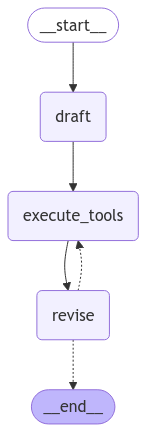

In [25]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_6N74aHkSSvEdFU4WfgjesqPX)
 Call ID: call_6N74aHkSSvEdFU4WfgjesqPX
  Args:
    answer: Addressing the climate crisis requires a multi-faceted approach that combines immediate action, long-term strategies, and international cooperation. Firstly, individuals and communities can reduce their carbon footprints by adopting sustainable practices such as using public transportation, reducing waste, and conserving energy. Educational initiatives can also empower citizens to understand the impact of their choices and engage in advocacy.

Secondly, governments play a vital role by implementing policies that promote renewable energy sources, like solar and wind, while phasing out fossil fuels. Legislation, such as carbon pricing, and investment in g